# 015. Isolated Forest 를 이용한 NYC Taxi 탑승 정보 anomaly 검출

In [21]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.ensemble import IsolationForest
import seaborn as sns

- 2014년 7월 부터 2015년 1월까지의 New York taxi 탑승 횟수 정보를 30분 단위로 기록

In [22]:
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
df = pd.read_csv(url)
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.4+ KB


- timestamp column 을 datetime64 로 변경

In [24]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


## Feature Engineering
- index 를 time series 로 바꾸고, 1 시간 단위로 resample

In [25]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [26]:
df = df.set_index('timestamp').resample('H').mean().reset_index()
df.head()

,timestamp,value
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


- `hour`, `weekday` column 추가

In [27]:
df['hour'] = df.timestamp.dt.hour
df['weekday'] = pd.Categorical(df.timestamp.dt.strftime('%A'), 
                               categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  5160 non-null   datetime64[ns]
 1   value      5160 non-null   float64       
 2   hour       5160 non-null   int64         
 3   weekday    5160 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 126.4 KB


- 요일별 평균 탑승 횟수 시각화

In [29]:
df.head()

,timestamp,value,hour,weekday
0,2014-07-01 00:00:00,9485.5,0,Tuesday
1,2014-07-01 01:00:00,5433.0,1,Tuesday
2,2014-07-01 02:00:00,3346.5,2,Tuesday
3,2014-07-01 03:00:00,2216.5,3,Tuesday
4,2014-07-01 04:00:00,2189.5,4,Tuesday


<AxesSubplot:xlabel='weekday'>

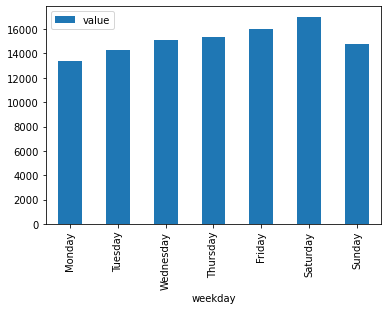

In [30]:
df[['value', 'weekday']].groupby('weekday').mean().plot(kind='bar')

<AxesSubplot:xlabel='hour'>

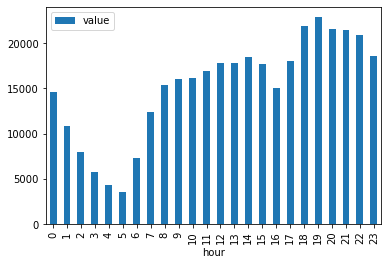

In [31]:
df[['value', 'hour']].groupby('hour').mean().plot(kind='bar')

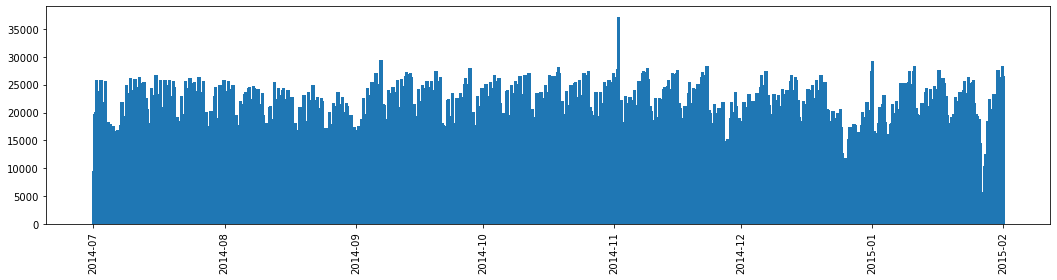

In [32]:
plt.figure(figsize=(18, 4))
plt.bar(df.timestamp, df.value)
plt.xticks(rotation=90);

2014.11 부근에 큰 peak 가 보이고, 2015.2 이전에 매우 작은 값이 보인다.

<AxesSubplot:xlabel='timestamp'>

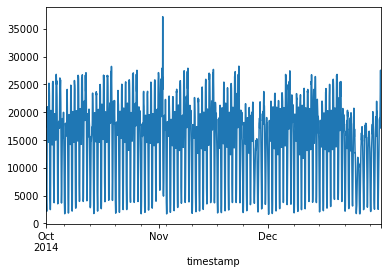

In [33]:
series = df.set_index('timestamp').loc['2014-10':'2014-12']['value']
series.plot()

<AxesSubplot:xlabel='timestamp'>

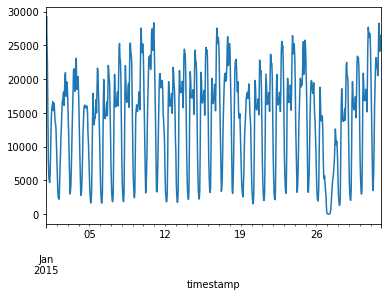

In [34]:
series = df.set_index('timestamp').loc['2015-01':'2015-02']['value']
series.plot()

2014-11-02 는 뉴욕마라톤. 2015-01-27 에는 눈보라가 있었음.

### 방법 1 - parameter 를 이용한 threshold control  
contamination parameter 는 이상값으로 간주되어야 하는 경우에 대한 임계값을 제어합니다.

In [35]:
model = IsolationForest(contamination=0.004, random_state=0)
model.fit(df[['value']].values)

IsolationForest(contamination=0.004, random_state=0)

In [36]:
np.unique(model.predict(df[['value']].values))

array([-1,  1])

outliers 검출. anomaly 는 -1.

In [37]:
df['outliers'] = pd.Series(model.predict(df[['value']].values)).apply(lambda x: 'yes' if (x == -1) else 'no')

In [38]:
df.query('outliers == "yes"')

,timestamp,value,hour,weekday,outliers
1631,2014-09-06 23:00:00,29418.5,23,Saturday,yes
2135,2014-09-27 23:00:00,28024.5,23,Saturday,yes
2639,2014-10-18 23:00:00,28253.5,23,Saturday,yes
2971,2014-11-01 19:00:00,27912.0,19,Saturday,yes
2977,2014-11-02 01:00:00,37204.5,1,Sunday,yes
3143,2014-11-08 23:00:00,27926.0,23,Saturday,yes
3479,2014-11-22 23:00:00,28299.0,23,Saturday,yes
4417,2015-01-01 01:00:00,29292.0,1,Thursday,yes
4655,2015-01-10 23:00:00,28351.0,23,Saturday,yes
5039,2015-01-26 23:00:00,243.0,23,Monday,yes


<AxesSubplot:xlabel='timestamp', ylabel='value'>

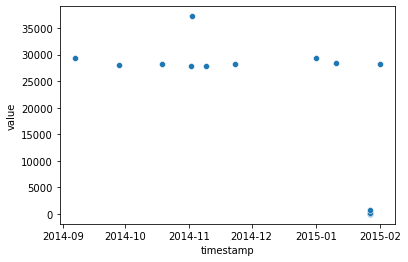

In [39]:
sns.scatterplot(x='timestamp', y='value', data=df.query('outliers == "yes"'))

### 방법 2 - 임의의 threshold 설정 

scores - 입력 샘플의 anomaly score 입니다. 낮을수록 비정상적입니다. 음수 점수는 outlier를 나타내고 양수 점수는 inlier를 나타냅니다.

In [40]:
model = IsolationForest(random_state=0)
model.fit(df[['value']].values)

IsolationForest(random_state=0)

In [41]:
score = model.decision_function(df[['value']].values)
score

array([-0.01295257, -0.03374763, -0.01858539, ..., -0.02806426,
       -0.10541479, -0.09735689])

Text(0, 0.5, 'frequencey')

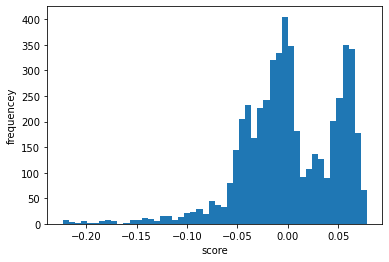

In [42]:
plt.hist(score, bins=50);
plt.xlabel("score")
plt.ylabel("frequencey")

In [43]:
df['score'] = score
df

,timestamp,value,hour,weekday,outliers,score
0,2014-07-01 00:00:00,9485.5,0,Tuesday,no,-0.012953
1,2014-07-01 01:00:00,5433.0,1,Tuesday,no,-0.033748
2,2014-07-01 02:00:00,3346.5,2,Tuesday,no,-0.018585
3,2014-07-01 03:00:00,2216.5,3,Tuesday,no,-0.064383
4,2014-07-01 04:00:00,2189.5,4,Tuesday,no,-0.070976
...,...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,yes,-0.203992
5156,2015-01-31 20:00:00,24138.0,20,Saturday,no,-0.028141
5157,2015-01-31 21:00:00,24194.5,21,Saturday,no,-0.028064
5158,2015-01-31 22:00:00,26515.0,22,Saturday,no,-0.105415


In [44]:
df.query('score < -0.15')

,timestamp,value,hour,weekday,outliers,score
1515,2014-09-02 03:00:00,1653.5,3,Tuesday,no,-0.154163
1630,2014-09-06 22:00:00,27414.0,22,Saturday,no,-0.176655
1631,2014-09-06 23:00:00,29418.5,23,Saturday,yes,-0.207812
1775,2014-09-12 23:00:00,27331.5,23,Friday,no,-0.174276
1942,2014-09-19 22:00:00,27385.5,22,Friday,no,-0.177113
2135,2014-09-27 23:00:00,28024.5,23,Saturday,yes,-0.199718
2471,2014-10-11 23:00:00,27117.5,23,Saturday,no,-0.154806
2635,2014-10-18 19:00:00,27341.0,19,Saturday,no,-0.174276
2639,2014-10-18 23:00:00,28253.5,23,Saturday,yes,-0.203992
2640,2014-10-19 00:00:00,27146.5,0,Sunday,no,-0.157615


contamination parameter 와 임의로 설정한 threshold 결과를 비교하며 domain knowlege 이용하여 outlier 를 구분하면 된다.